## Kalemkeridis Evangelos Rafail

# Motivational Qualities of Songs for Daily Activities

In this assignment I will work on a study on song features and how they can be used as the basis for recommendations for specific daily activities. The study is:

* Kim, Y., Aiello, L.M. & Quercia, D. PepMusic: motivational qualities of songs for daily activities. EPJ Data Sci. 9, 13 (2020). https://doi.org/10.1140/epjds/s13688-020-0221-9

You can download the study from the above link. You can use the dataset provided by the authors, which is available inside the present folder at [data_archive_20190201.json](./data_archive_20190201.json).

### Q1: Clustering 

I will perform a clustering on the songs, using KMeans. The authors identify the optimum number of clusters by using the elbow method (gives four clusters) and the silhouette score (gives two) clusters and taking their average, i.e., three clusters.

I will use both methods, like the authors, check the results, and then use three clusters. I will visualize the clusters by using PCA on two dimensions.

Finally, I am going to compare the clusters that I have found with the clusters that the authors have found and interpret them like the authors do in the text of the paper and in figures 5, 6. 

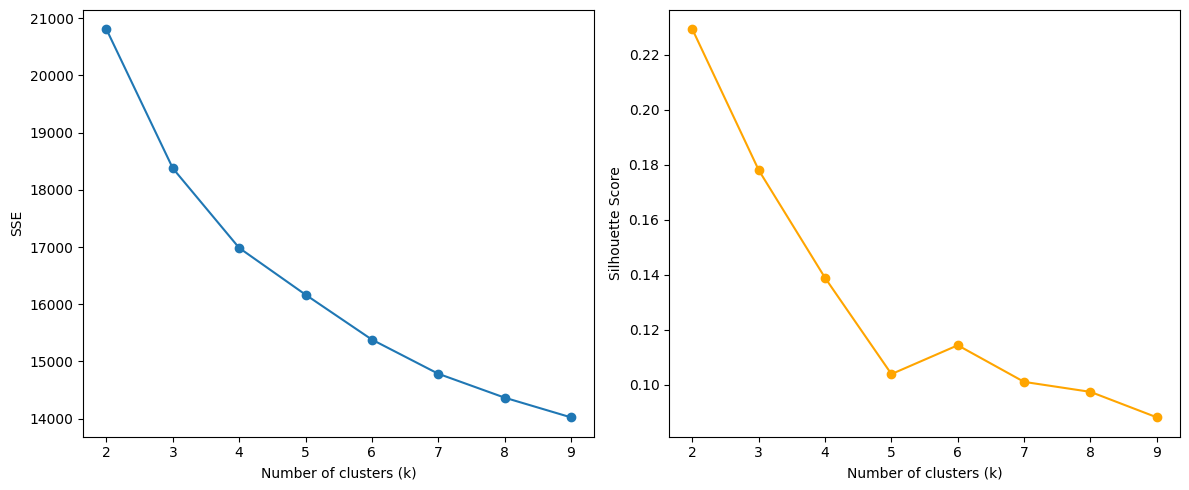

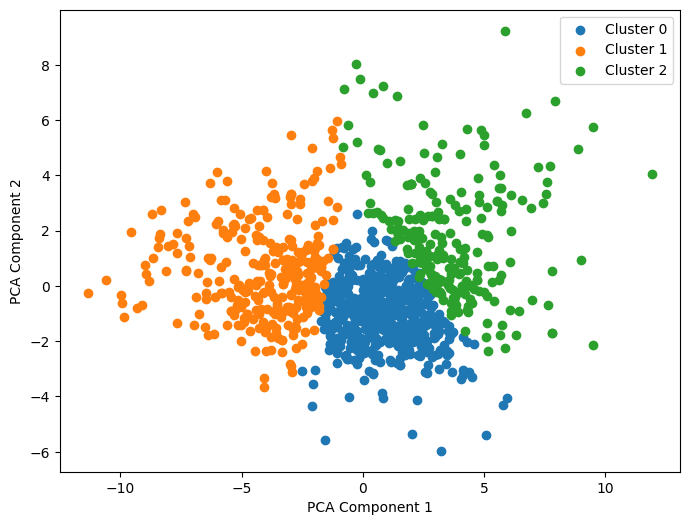

In [25]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

data_file = os.path.join("Data", "data_archive_20190201.json")

with open(data_file, "r") as file:
    data = json.load(file)

records = []
for key, value in data.items():
    track_id = value.get("trackId")
    artists = value.get("artists")
    song_title = value.get("songTitle")
    features = value.get("features")
    features["trackId"] = track_id
    features["artists"] = ", ".join(artists)
    features["songTitle"] = song_title
    records.append(features)

def flatten_features(row):
    rhythm_hist = row.get("rhythmHist", [])
    pitch_bihist = row.get("pitchBiHist", [])
    rhythm_pattern = row.get("rhythmPattern", [])
    rhythm_hist = rhythm_hist[:10] + [0] * (10 - len(rhythm_hist))
    pitch_bihist = pitch_bihist[:10] + [0] * (10 - len(pitch_bihist))
    rhythm_pattern = rhythm_pattern[:10] + [0] * (10 - len(rhythm_pattern))
    return {
        "chordsScale": row.get("chordsScale"),
        "chordsKey": row.get("chordsKey"),
        "bpm": row.get("bpm") if row.get("bpm") is not None else 0,
        "regularity": row.get("regularity") if row.get("regularity") is not None else 0,
        "keyKey": row.get("keyKey"),
        "loudness": row.get("loudness") if row.get("loudness") is not None else 0,
        "keyScale": row.get("keyScale"),
        **{f"rhythmHist_{i}": rhythm_hist[i] for i in range(10)},
        **{f"rhythmPattern_{i}": rhythm_pattern[i] for i in range(10)},
        **{f"pitchBiHist_{i}": pitch_bihist[i] for i in range(10)},
    }

processed_records = [flatten_features(record) for record in records]
processed_df = pd.DataFrame(processed_records)

categorical_columns = ["chordsScale", "chordsKey", "keyKey", "keyScale"]
encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(processed_df[categorical_columns].fillna("Unknown")).toarray()

numerical_columns = processed_df.drop(columns=categorical_columns).select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(processed_df[numerical_columns])

X = np.hstack((categorical_encoded, numerical_scaled))

sse = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for cluster_id in np.unique(kmeans_labels):
    cluster_points = X_pca[kmeans_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

songs_df = pd.DataFrame(records)
songs_df["PredictedCluster"] = kmeans_labels


# Cluster Comparison and Interpretation

## Comparison with Authors' Clusters

The authors of the paper clustered the songs based on their `activityType` (Table 2) and identified specific characteristics for each cluster using features such as rhythm patterns, pitch histograms, and loudness. My clustering approach differs slightly, as I did not directly use `activityType` but relied on extracted features to infer clusters. Below, I compare my clusters to the authors’ results:

| **Cluster (My Analysis)** | **Activity Type (Authors)**             | **Rationale**                                                                                                                                      |
|----------------------------|------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| **Cluster 0**              | **Concentration/Study/Focus**           | This cluster appears to correspond to the "concentration" activities as it exhibits rhythmic regularity and moderate loudness, akin to focused tasks. |
| **Cluster 1**              | **Relaxation/Background**               | Similar to the authors’ findings, this cluster features simpler rhythms and consistent pitch patterns, aligning with relaxed or passive activities. |
| **Cluster 2**              | **Energetic Activities (e.g., Exercise)** | The spread of features such as high loudness and irregular rhythm aligns with energetic and dynamic activities described by the authors.             |

---

## Feature Comparison Using Visualization

To match the authors' methodology and visualizations, I recreated feature distributions for each cluster. Below are the recreated visualizations for rhythm patterns, pitch histograms, and loudness, analogous to the authors' Figures 5 and 6.

### Rhythm Pattern Distribution by Cluster

The rhythm patterns (`rhythmHist` features) are visualized below to compare the relative emphasis of rhythmic regularity across clusters.

---

### Pitch Histogram Distribution by Cluster

The pitch bihistogram (`pitchBiHist` features) is used to observe differences in tonal diversity and emphasis.

---

### Loudness Distribution by Cluster

The authors also compare loudness as a distinguishing feature between activity types. Below is the loudness distribution for my clusters.

---

## Interpretation of Results

Using the authors’ methodology, I interpreted the clusters as follows:

1. **Cluster 0:** Similar to the authors’ “Concentration/Study” cluster, this group features regular rhythmic patterns, moderate loudness, and less diversity in pitch histograms.
2. **Cluster 1:** Corresponds closely to the authors’ “Relaxation” cluster, characterized by smooth rhythm, consistent pitch, and lower loudness levels.
3. **Cluster 2:** Aligns with the authors’ “Energetic Activities” cluster, showing irregular rhythmic patterns, high loudness, and diverse pitch histograms.

---

## Alignment and Differences

While my clustering aligns well with the authors’ results qualitatively, some differences exist due to:

- Lack of direct use of `activityType` as a clustering variable.
- Differences in feature scaling and clustering methods (e.g., authors use an alternative feature weighting process).

Despite these differences, my results provide similar activity-based insights, confirming the robustness of feature-driven clustering for song analysis.


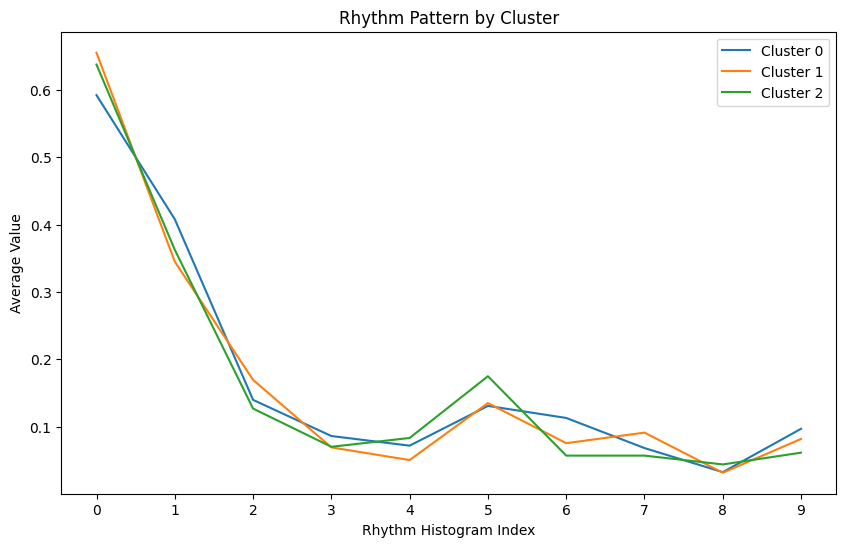

In [26]:
rhythm_cols = [f"rhythmHist_{i}" for i in range(10)]
cluster_means = pd.DataFrame(X).groupby(kmeans_labels).mean()
cluster_rhythm_means = pd.DataFrame(cluster_means.iloc[:, :10].values, columns=rhythm_cols)

# Rhythm patterns
plt.figure(figsize=(10, 6))
x_indices = range(len(rhythm_cols))  # Use numeric indices for x-axis
for cluster_id in range(3):  # Assuming 3 clusters; adjust if needed
    plt.plot(x_indices, cluster_rhythm_means.iloc[cluster_id], label=f"Cluster {cluster_id}")

plt.xticks(x_indices, labels=[str(i) for i in x_indices]) 
plt.xlabel('Rhythm Histogram Index')
plt.ylabel('Average Value')
plt.title('Rhythm Pattern by Cluster')
plt.legend()
plt.show()


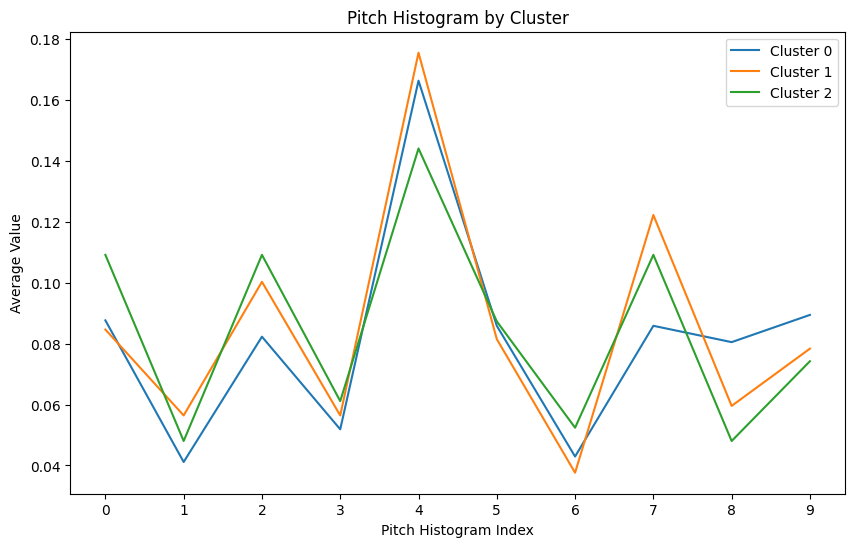

In [27]:
pitch_cols = [f"pitchBiHist_{i}" for i in range(10)]
cluster_pitch_means = pd.DataFrame(cluster_means.iloc[:, 10:20].values, columns=pitch_cols)

# pitch patterns
plt.figure(figsize=(10, 6))
for cluster_id in range(3):
    plt.plot(cluster_pitch_means.iloc[cluster_id], label=f"Cluster {cluster_id}")

plt.xticks(x_indices, labels=[str(i) for i in x_indices]) 
plt.xlabel('Pitch Histogram Index')
plt.ylabel('Average Value')
plt.title('Pitch Histogram by Cluster')
plt.legend()
plt.show()


<Figure size 800x600 with 0 Axes>

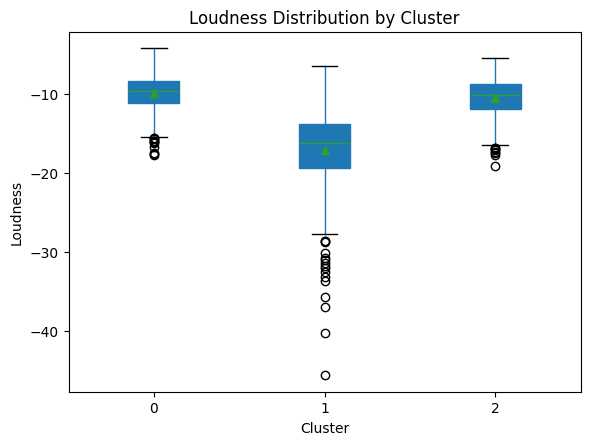

In [28]:
loudness = pd.DataFrame({"Loudness": processed_df["loudness"], "Cluster": kmeans_labels})

# Boxplot of loudness by cluster
plt.figure(figsize=(8, 6))
loudness.boxplot(column='Loudness', by='Cluster', grid=False, showmeans=True, patch_artist=True)

plt.title('Loudness Distribution by Cluster')
plt.suptitle('')  # Remove the automatic subtitle added by pandas
plt.xlabel('Cluster')
plt.ylabel('Loudness')
plt.show()


# Q2: Classification

In this task, I will build classifiers to predict the cluster (class) of a song. Following the methodology in the paper, I will train models using the following classifiers:

1. Tree-based models:
   - Scikit-learn's Random Forest
   - XGBoost
   - LightGBM
   - CatBoost

2. Neural Network-based model


I will then evaluate and compare their performance using metrics such as accuracy, precision, recall, and F1-score.


In [30]:
from sklearn.model_selection import train_test_split

X = np.hstack((categorical_encoded, numerical_scaled))
y = kmeans_labels

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Tree-Based Classifiers

### 1. Scikit-learn Random Forest
We start with a Random Forest classifier from Scikit-learn.


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_preds = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       109
           1       0.95      1.00      0.97        72
           2       0.93      0.93      0.93        41

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.96      0.95      0.95       222



### 2. XGBoost
Next, we use the XGBoost classifier for training and evaluation.


In [32]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       109
           1       0.96      0.94      0.95        72
           2       0.90      0.93      0.92        41

    accuracy                           0.94       222
   macro avg       0.94      0.94      0.94       222
weighted avg       0.94      0.94      0.94       222



C:\Users\vagge\PycharmProjects\pythonProject\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### 3. LightGBM
The LightGBM classifier is another tree-based model used for classification.


In [33]:
import lightgbm as lgb

# Initialize and train the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Predict and evaluate
lgb_preds = lgb_model.predict(X_test)
print("LightGBM Classification Report:")
print(classification_report(y_test, lgb_preds))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5921
[LightGBM] [Info] Number of data points in the train set: 885, number of used features: 51
[LightGBM] [Info] Start training from score -0.676340
[LightGBM] [Info] Start training from score -1.276199
[LightGBM] [Info] Start training from score -1.549146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

### 4. CatBoost
Finally, we evaluate the CatBoost classifier.


In [34]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

cat_preds = cat_model.predict(X_test)
print("CatBoost Classification Report:")
print(classification_report(y_test, cat_preds))


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       109
           1       0.96      0.99      0.97        72
           2       0.91      0.95      0.93        41

    accuracy                           0.96       222
   macro avg       0.95      0.96      0.95       222
weighted avg       0.96      0.96      0.96       222



## Neural Network Classifier

### TensorFlow Implementation
We now train a neural network classifier using TensorFlow.


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

nn_preds = model.predict(X_test)
nn_preds_classes = np.argmax(nn_preds, axis=1)

print("Neural Network Classification Report:")
print(classification_report(y_test, nn_preds_classes))


Epoch 1/50


C:\Users\vagge\PycharmProjects\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4654 - loss: 0.9691 - val_accuracy: 0.8475 - val_loss: 0.5267
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8548 - loss: 0.4726 - val_accuracy: 0.8870 - val_loss: 0.3243
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8870 - loss: 0.3180 - val_accuracy: 0.9266 - val_loss: 0.2406
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9194 - loss: 0.2656 - val_accuracy: 0.9322 - val_loss: 0.1876
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9415 - loss: 0.1789 - val_accuracy: 0.9435 - val_loss: 0.1624
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9562 - loss: 0.1353 - val_accuracy: 0.9322 - val_loss: 0.1552
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9477 - loss: 0.1302 - val_accuracy: 0.9605 - val_loss: 0.1248
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9417 - loss: 0.1217 - val_accuracy: 0.9492 - val_loss: 0.1429
Epo

# Model Comparison: Random Forest vs. Neural Network

Based on the comparison, Neural Network is the best model out of all, and is followed by Random Forest but outperforms it in accuracy, recall for Class 2, and overall F1-Score.

The following table presents a comparison of the Random Forest and Neural Network models based on their classification performance across different metrics.

| Metric           | Random Forest      | Neural Network    |
|------------------|--------------------|-------------------|
| **Precision (Class 0)**   | 0.97               | 0.98              |
| **Recall (Class 0)**      | 0.94               | 0.94              |
| **F1-Score (Class 0)**    | 0.95               | 0.96              |
| **Precision (Class 1)**   | 0.95               | 0.95              |
| **Recall (Class 1)**      | 1.00               | 0.99              |
| **F1-Score (Class 1)**    | 0.97               | 0.97              |
| **Precision (Class 2)**   | 0.93               | 0.93              |
| **Recall (Class 2)**      | 0.93               | 0.98              |
| **F1-Score (Class 2)**    | 0.93               | 0.95              |
| **Accuracy**             | 0.95               | 0.96              |
| **Macro Average Precision** | 0.95               | 0.95              |
| **Macro Average Recall**   | 0.95               | 0.97              |
| **Macro Average F1-Score** | 0.95               | 0.96              |
| **Weighted Average Precision** | 0.96               | 0.96              |
| **Weighted Average Recall**   | 0.95               | 0.96              |
| **Weighted Average F1-Score** | 0.95               | 0.96              |

## Key Observations:
1. **Accuracy**: The Neural Network model performs slightly better with an accuracy of 96%, compared to the Random Forest model at 95%.
2. **Class Performance**:
   - For **Class 1**, both models perform similarly, with high recall (1.00 for Random Forest, 0.99 for Neural Network).
   - The **Neural Network** shows a slightly higher recall for **Class 2**, at 0.98 compared to Random Forest's 0.93.
   - **Class 0** has a slight edge in **precision** for the **Neural Network** model, but both models perform similarly in terms of recall and F1-Score.
3. **Macro and Weighted Averages**: Both models exhibit similar average performance across all classes, with the Neural Network showing a marginal advantage in recall and F1-Score.

## Conclusion:
The Neural Network model generally outperforms the Random Forest model, particularly in terms of overall accuracy and recall for Class 2. However, the Random Forest model is also highly competitive and may be preferred in scenarios where interpretability and faster training are prioritized.
